# Customer review sentiment analysis on amazon product

### Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import re
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud




#### Dataset link in onedrive
**https://mylambton-my.sharepoint.com/:x:/r/personal/c0913119_mylambton_ca/Documents/amazon_reviews_us_Camera_v1_00.csv?d=w1288acb3ebc34c6ca3eafd9dc6425a9b&csf=1&web=1&e=XAjqTA**

In [2]:
# read csv file
df = pd.read_csv('amazon_reviews_us_Camera_v1_00.csv')

/var/folders/rt/sl_4lysj263gjhcvkksm21tr0000gn/T/ipykernel_22044/3275477740.py:2: DtypeWarning: Columns (1,7,8,9,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('amazon_reviews_us_Camera_v1_00.csv')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 22 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   marketplace        1048575 non-null  object 
 1   customer_id        1048575 non-null  object 
 2   review_id          1048557 non-null  object 
 3   product_id         1048557 non-null  object 
 4   product_parent     1048557 non-null  float64
 5   product_title      1048557 non-null  object 
 6   product_category   1048557 non-null  object 
 7   star_rating        1048557 non-null  object 
 8   helpful_votes      1048557 non-null  object 
 9   total_votes        1048557 non-null  object 
 10  vine               1048556 non-null  object 
 11  verified_purchase  1048556 non-null  object 
 12  review_headline    1048547 non-null  object 
 13  review_body        1048462 non-null  object 
 14  review_date        1048532 non-null  object 
 15  Unnamed: 15        39 non-null  

In [4]:
# print first few rows
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,...,review_headline,review_body,review_date,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21
0,US,2975964,R1NBG94582SJE2,B00I01JQJM,860486164.0,GoPro Rechargeable Battery 2.0 (HERO3/HERO3+ o...,Camera,5,0,0,...,Five Stars,ok,31/08/2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,US,23526356,R273DCA6Y0H9V7,B00TCO0ZAA,292641483.0,Professional 58mm Center Pinch Lens Cap for CA...,Camera,5,0,0,...,Love it!!!,"Perfect, even sturdier than the original!",31/08/2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,US,52764145,RQVOXO7WUOFK6,B00B7733E0,75825744.0,Spy Tec Z12 Motion Activated Intelligent Secur...,Camera,2,1,1,...,Another Motion Detect Fail,"If the words, &#34;Cheap Chinese Junk&#34; com...",31/08/2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,US,47348933,R1KWKSF21PO6HO,B006ZN4U34,789352955.0,"Celestron UpClose G2 10x25 Monocular, Black (7...",Camera,5,0,0,...,Exactly what I wanted and expected.,Exactly what I wanted and expected. Perfect fo...,31/08/2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,US,33680700,R38H3UO1J190GI,B00HUEBGMU,19067902.0,Vidpro XM-L Wired Lavalier microphone - 20' Au...,Camera,5,1,1,...,Good mic at a Good Price...Not Canon Though.,I will look past the fact that they tricked me...,31/08/2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.shape

(1048575, 22)

**columns 'Unnamed: 15'  to 'Unnamed: 21' are unwanted columns, with mostly NaN values, we will remove this columns**

In [6]:
df.drop(['Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21'], axis=1, inplace=True)

In [7]:
# gives the list of columns in the df
df.columns

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date'],
      dtype='object')

###
For this project, we will consider star_rating & review_body columns for sentiment analysis
1) check the unique values of star_rating, 
2) check for null values in star_rating & review_body

In [8]:
df['star_rating'].value_counts(dropna=False)

star_rating
5               625901
4               173244
1                91360
3                77258
2                48026
5                20820
4                 5232
1                 2828
3                 2400
2                 1487
NaN                 18
Great value!         1
Name: count, dtype: int64

In the above unique value counts, we can see that:
1) There are only 18 null values & considering the amount of data we can drop the null values.
2) There is one row with rating as a string, we will drop that row for now.
3) Also, we can notice that the rating 5, 4, 3, 2, 1 are repeated, which can be due to different datatype.  Let's explore that further

In [9]:
df['star_rating'].dtype

dtype('O')

In [10]:
# check the row with star_rating = 'Great value!'
df[df['star_rating'] == 'Great value!']

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
268260,4-5.6 ED WR Lenses +eFonto Cleaning Paper Tiss...,Camera,5,0,0.0,N,Y,Great value!,"Fits perfectly, and much less expensive than n...",28/03/2015,NaN,NaN,NaN,NaN,NaN


In [11]:
# remove the row with star_rating = 'Great value!'
df = df[df['star_rating'] != 'Great value!']

In [12]:
df[df['star_rating'] == 'Great value!']

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date


In [13]:
# drop rows with null value of column star_rating
df.dropna(subset=['star_rating'], inplace=True)

In [14]:
df['star_rating'].value_counts(dropna=False)

star_rating
5    625901
4    173244
1     91360
3     77258
2     48026
5     20820
4      5232
1      2828
3      2400
2      1487
Name: count, dtype: int64

In [15]:
# convert the datatype to int
df['star_rating'] = df['star_rating'].astype('int')

In [16]:
df['star_rating'].dtype

dtype('int64')

In [17]:
df['star_rating'].value_counts(dropna=False)

star_rating
5    646721
4    178476
1     94188
3     79658
2     49513
Name: count, dtype: int64

Here, we can see that the null values are dropped & the unique value are not repeated after converting datatype of star_rating to int

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1048556 entries, 0 to 1048574
Data columns (total 15 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   marketplace        1048556 non-null  object 
 1   customer_id        1048556 non-null  object 
 2   review_id          1048556 non-null  object 
 3   product_id         1048556 non-null  object 
 4   product_parent     1048556 non-null  float64
 5   product_title      1048556 non-null  object 
 6   product_category   1048556 non-null  object 
 7   star_rating        1048556 non-null  int64  
 8   helpful_votes      1048556 non-null  object 
 9   total_votes        1048556 non-null  object 
 10  vine               1048556 non-null  object 
 11  verified_purchase  1048556 non-null  object 
 12  review_headline    1048547 non-null  object 
 13  review_body        1048462 non-null  object 
 14  review_date        1048532 non-null  object 
dtypes: float64(1), int64(1), object(13)
m

In [19]:
# drop the rows with review_body null
review_df = df.dropna(subset=['review_body'], axis=0)

In [20]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1048462 entries, 0 to 1048574
Data columns (total 15 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   marketplace        1048462 non-null  object 
 1   customer_id        1048462 non-null  object 
 2   review_id          1048462 non-null  object 
 3   product_id         1048462 non-null  object 
 4   product_parent     1048462 non-null  float64
 5   product_title      1048462 non-null  object 
 6   product_category   1048462 non-null  object 
 7   star_rating        1048462 non-null  int64  
 8   helpful_votes      1048462 non-null  object 
 9   total_votes        1048462 non-null  object 
 10  vine               1048462 non-null  object 
 11  verified_purchase  1048462 non-null  object 
 12  review_headline    1048453 non-null  object 
 13  review_body        1048462 non-null  object 
 14  review_date        1048440 non-null  object 
dtypes: float64(1), int64(1), object(13)
m

**In amazon review, we can see if the review is from verified purchase or not, as we are doing sentiment analysis we will only use reviews from the verified purchase only**

In [21]:
# check unique values with count for verified_purchase
review_df['verified_purchase'].value_counts()

verified_purchase
Y    945401
N    103061
Name: count, dtype: int64

In [22]:
# remove the unverified purchase data
review_df = review_df[review_df['verified_purchase'] != 'N']

In [23]:
review_df['verified_purchase'].value_counts()

verified_purchase
Y    945401
Name: count, dtype: int64

In [24]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 945401 entries, 0 to 1048574
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   marketplace        945401 non-null  object 
 1   customer_id        945401 non-null  object 
 2   review_id          945401 non-null  object 
 3   product_id         945401 non-null  object 
 4   product_parent     945401 non-null  float64
 5   product_title      945401 non-null  object 
 6   product_category   945401 non-null  object 
 7   star_rating        945401 non-null  int64  
 8   helpful_votes      945401 non-null  object 
 9   total_votes        945401 non-null  object 
 10  vine               945401 non-null  object 
 11  verified_purchase  945401 non-null  object 
 12  review_headline    945393 non-null  object 
 13  review_body        945401 non-null  object 
 14  review_date        945389 non-null  object 
dtypes: float64(1), int64(1), object(13)
memory usage: 115.4

### All the available columns are not required to be used for sentiment analysis, only columns that are important will be kept in the df. We can remove the columns that are not required

In [25]:
review_df = review_df[['product_id', 'product_title', 'star_rating', 'review_body']]

In [26]:
review_df.head()

,product_id,product_title,star_rating,review_body
0,B00I01JQJM,GoPro Rechargeable Battery 2.0 (HERO3/HERO3+ o...,5,ok
1,B00TCO0ZAA,Professional 58mm Center Pinch Lens Cap for CA...,5,"Perfect, even sturdier than the original!"
2,B00B7733E0,Spy Tec Z12 Motion Activated Intelligent Secur...,2,"If the words, &#34;Cheap Chinese Junk&#34; com..."
3,B006ZN4U34,"Celestron UpClose G2 10x25 Monocular, Black (7...",5,Exactly what I wanted and expected. Perfect fo...
4,B00HUEBGMU,Vidpro XM-L Wired Lavalier microphone - 20' Au...,5,I will look past the fact that they tricked me...


**Creating a column target_start_rating to take sample of data based on ratings**

In [27]:
review_df['target_star_rating'] = np.where(review_df['star_rating']>3, 'positive', 'negative')

In [28]:
review_df['target_star_rating'].value_counts()

target_star_rating
positive    750092
negative    195309
Name: count, dtype: int64

In [29]:
# Created a balanced dataset based on target_star_rating column
balanced_review_df = review_df.groupby('target_star_rating').sample(n=review_df['target_star_rating'].value_counts().min(), random_state=42)

In [30]:
balanced_review_df['target_star_rating'].value_counts()

target_star_rating
negative    195309
positive    195309
Name: count, dtype: int64

In [31]:
balanced_review_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 390618 entries, 284483 to 68777
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   product_id          390618 non-null  object
 1   product_title       390618 non-null  object
 2   star_rating         390618 non-null  int64 
 3   review_body         390618 non-null  object
 4   target_star_rating  390618 non-null  object
dtypes: int64(1), object(4)
memory usage: 17.9+ MB


**Now, the data is clean with no null values and with required columns only**

## Text Preprocessing 
**review column**

In [32]:
!pip install contractions

In [33]:
import contractions

In [34]:
lem = WordNetLemmatizer()
def word_lemmatization(word):
    return lem.lemmatize(word)
    

In [35]:
def fix_contracted_words(word):
    return contractions.fix(word)

In [36]:
word_length_pattern = re.compile(r"(.)\1{2,}")
def remove_word_lengthening(word):
    return word_length_pattern.sub(r"\1\1", word)

In [37]:
# Function that will handle text preprocessing
def text_cleaning(text):
    # convert to lower case
    text = text.lower()
    # remove HTML characters
    html_regex = r'<.*?>'
    text = re.sub(html_regex, '', text)
    # remove numbers from text
    text = re.sub(r'\d+', '', text)
    # remove punctuations & special characters
    text = text.translate(str.maketrans('','', string.punctuation))
    # fix text word contraction
    text = fix_contracted_words(text)
    # remove stopwords from text as they don't carry meaningful information
    stop_words = stopwords.words('english')
    # remove the negative words from stopwords (printing the stop_words shows that most negative words are at the end of list, so filtering the stopwords upto 143)
    filtered_stop_words = stop_words[:143]
    # remove additional negative words from stop_words
    neg_words = ["no", "nor", "not", "don", "don't"]
    filtered_stop_words = [word for word in filtered_stop_words if word not in neg_words]
    # remove stopwords from text

    wordlist = word_tokenize(text)
    for word in wordlist:
        if word not in filtered_stop_words:
            # remove word lengthening
            word = remove_word_lengthening(word)
            # perform word lemmatization
            word =  word_lemmatization(word)
        else:
            wordlist.remove(word)
            
    return " ".join(wordlist)
    
    
    

In [38]:
balanced_review_df['cleaned_review_body'] = ''

for i, review in balanced_review_df.iterrows():
    # add the cleaned review body to a new column in the df
    balanced_review_df.at[i, 'cleaned_review_body'] = text_cleaning(review['review_body'])

balanced_review_df.head()
    

,product_id,product_title,star_rating,review_body,target_star_rating,cleaned_review_body
284483,B004P8K24W,D-Link Wireless Day/Night microSD Network Surv...,3,We use it mainly to see who comes in and out o...,negative,use mainly see comes warehouse not expect clea...
950117,B003EB0AY8,Fotodiox Pro Lens Mount Adapter - Minolta Rokk...,1,This adapter creates awful chromatic aberratio...,negative,adapter creates awful chromatic aberration sof...
521269,B009CN8VNE,Contour 4165 Profile Mounts for Camera (Black),3,On curved applications (helmet and motorcycle ...,negative,curved applications helmet motorcycle fender m...
731226,B005AF0BZO,AGPtek® USB 800X Digital Microscope endoscope ...,1,Shipped quickly by amazon. Although the instal...,negative,shipped quickly amazon although install wizard...
253213,B00DB21TCM,YONGNUO YN-568EX II Camera Flash Speedlite TTL...,3,Earlier models of this flash unit had a socket...,negative,earlier models flash unit socket attached exte...


In [39]:
balanced_review_df.tail()

,product_id,product_title,star_rating,review_body,target_star_rating,cleaned_review_body
857936,B004ZH7LZ6,rooCASE Carrying Case for Panasonic Lumix DMC-...,5,Very nice protection case. It takes good care ...,positive,nice protection case takes good care your came...
425788,B002RCLYXG,GoPro Head Strap Mount,5,Fits well to attach my go pro to a standard t...,positive,fits well attach go pro a standard tripod came...
1041681,B00AMLLAH4,ePhoto Large Off Camera Strip Softbox Soft Box...,5,Since i bought it I use it twice but the light...,positive,since bought use twice light awesome the mount...
945004,B0002EXF38,SLIK Pro-700 Tripod,5,This is a heavy tripod for added stability wit...,positive,heavy tripod added stability plenty height nee...
68777,B00G97ANN2,Caps & Rings / Altura Photo Center Pinch Lens ...,5,"Fast shipping for new products! As good as, if...",positive,fast shipping new products good if not better ...


## Feature Enginnering

### Vader Sentiment Analysis
**Using vader sentiment analysis, to analyse sentiment of review column & create a target label**

In [40]:
analyzer = SentimentIntensityAnalyzer()
# function takes the review & if compound value is greater than 0, return 1 i.e. positive else neg
def sentiment_analysis_score(review):   
    polarity_scores = analyzer.polarity_scores(review)
    return 1 if polarity_scores['compound'] > 0 else 0


In [41]:
balanced_review_df['review_label'] = ''

balanced_review_df['review_label'] = balanced_review_df['cleaned_review_body'].apply(sentiment_analysis_score)

In [42]:
balanced_review_df.head()

,product_id,product_title,star_rating,review_body,target_star_rating,cleaned_review_body,review_label
284483,B004P8K24W,D-Link Wireless Day/Night microSD Network Surv...,3,We use it mainly to see who comes in and out o...,negative,use mainly see comes warehouse not expect clea...,0
950117,B003EB0AY8,Fotodiox Pro Lens Mount Adapter - Minolta Rokk...,1,This adapter creates awful chromatic aberratio...,negative,adapter creates awful chromatic aberration sof...,1
521269,B009CN8VNE,Contour 4165 Profile Mounts for Camera (Black),3,On curved applications (helmet and motorcycle ...,negative,curved applications helmet motorcycle fender m...,0
731226,B005AF0BZO,AGPtek® USB 800X Digital Microscope endoscope ...,1,Shipped quickly by amazon. Although the instal...,negative,shipped quickly amazon although install wizard...,1
253213,B00DB21TCM,YONGNUO YN-568EX II Camera Flash Speedlite TTL...,3,Earlier models of this flash unit had a socket...,negative,earlier models flash unit socket attached exte...,0


In [43]:
# check the unique count of the label column
balanced_review_df['review_label'].value_counts()

review_label
1    262507
0    128111
Name: count, dtype: int64

In [44]:
# Let's take the equal sample of neg & pos to further process the steps
balanced_review_df = balanced_review_df.groupby('review_label').sample(n=balanced_review_df['review_label'].value_counts().min(), random_state=42)

In [45]:
balanced_review_df['review_label'].value_counts()

review_label
0    128111
1    128111
Name: count, dtype: int64

**Equal values of pos(1) & (2) can be noticed here**

In [46]:
balanced_review_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 256222 entries, 520555 to 730158
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   product_id           256222 non-null  object
 1   product_title        256222 non-null  object
 2   star_rating          256222 non-null  int64 
 3   review_body          256222 non-null  object
 4   target_star_rating   256222 non-null  object
 5   cleaned_review_body  256222 non-null  object
 6   review_label         256222 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 15.6+ MB


## Train-test data split

In [47]:
X = balanced_review_df['cleaned_review_body']
y = balanced_review_df['review_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Word vectorization

In [48]:
def plot_word_frequencies(words_list, title, n, color):
    
    # Convert the list to a DataFrame
    words_df = pd.DataFrame(words_list, columns=['Word', 'Value'])
    
    # Sort the DataFrame by frequency or score
    words_df.sort_values(by='Value', ascending=False, inplace=True)
    
    # Get the top n words
    top_words = words_df.head(n)
    
    # Create the bar chart
    plt.figure(figsize=(8, 6))
    plt.bar(top_words['Word'], top_words['Value'], color=color)
    plt.xticks(rotation=90)
    plt.xlabel('Words')
    plt.ylabel('Frequency/Score')
    plt.title(title)
    plt.show()


In [49]:
def plot_word_cloud(words_freq):
    width=800
    height=400
    background_color='white'
    figsize=(10,6)
    
    # Generate the word cloud
    wordcloud = WordCloud(width=width, height=height, background_color=background_color).generate_from_frequencies(dict(words_freq))
    
    # Plot
    plt.figure(figsize=figsize)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Hide the axes
    plt.show()


### Bag of words

In [50]:
# x_train & x_test using bag of words
count = CountVectorizer()

X_train_bag_of_words = count.fit_transform(list(X_train))
X_test_bag_of_words = count.transform(list(X_test))

In [51]:
# Sum up the counts of each vocabulary word
sum_words = X_train_bag_of_words.sum(axis=0) 
# Connect the word to its frequency
words_freq = [(word, sum_words[0, idx]) for word, idx in count.vocabulary_.items()]
# Sort the words by frequency
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

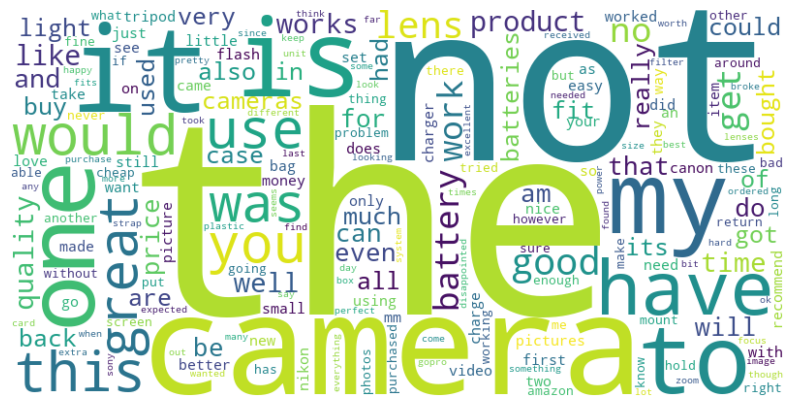

In [52]:
plot_word_cloud(words_freq)

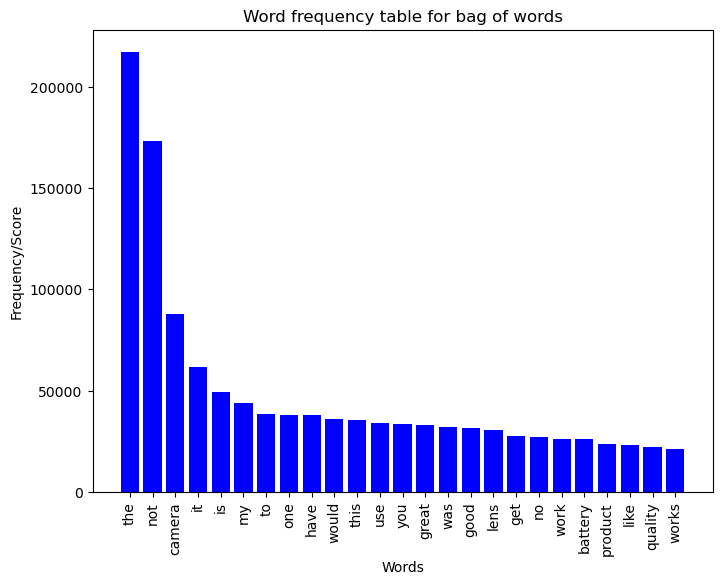

In [53]:
title = "Word frequency table for bag of words"
plot_word_frequencies(words_freq,title,25,"Blue")

### TF-IDF

In [54]:
# x_train & x_test using TfidfVectorizer
tfidf_count =  TfidfVectorizer()
X_train_tfidf = tfidf_count.fit_transform(list(X_train))
X_test_tfidf = tfidf_count.transform(list(X_test))

In [55]:
# Sum up the counts of each vocabulary word
sum_words1 = X_train_tfidf.sum(axis=0) 
# Connect the word to its frequency
words_freq1 = [(word, sum_words[0, idx]) for word, idx in count.vocabulary_.items()]
# Sort the words by frequency
words_freq1 =sorted(words_freq, key = lambda x: x[1], reverse=True)

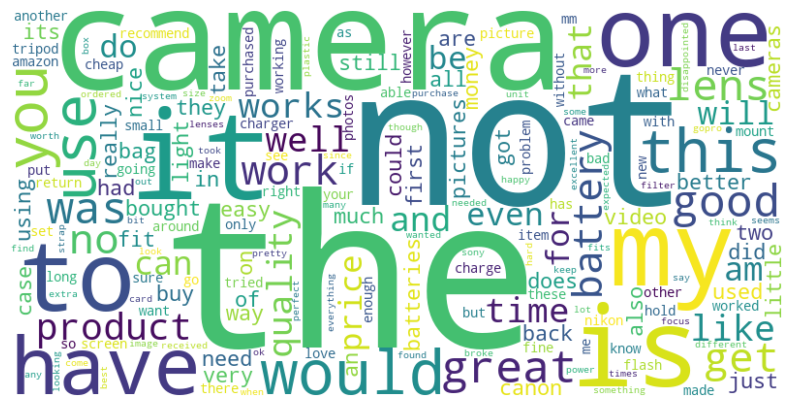

In [56]:
plot_word_cloud(words_freq1)

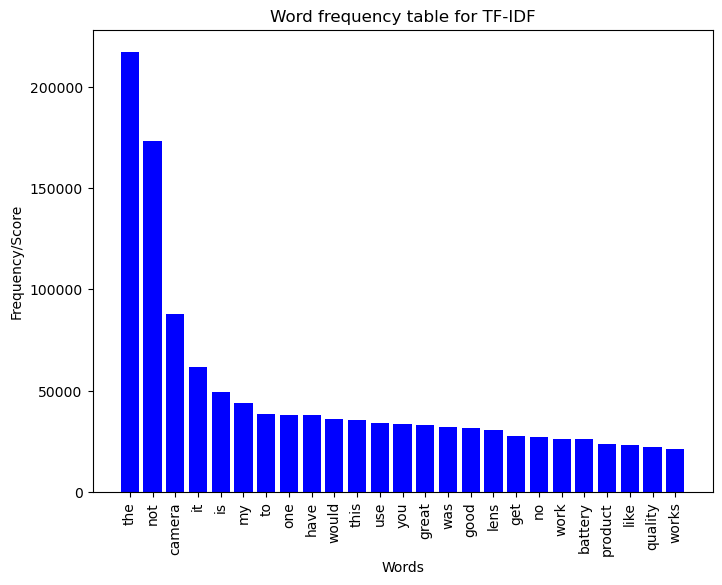

In [57]:
title = "Word frequency table for TF-IDF"
plot_word_frequencies(words_freq1,title,25,"Blue")

## Model Train & Test

In [58]:
# function to check metrics for model predicted & true values
def check_metrics(y_test, y_pred):
    print("Accuracy Score: ", accuracy_score(y_test, y_pred))
    print("Classification Report: ", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cbar=False)

### Logistic Model

In [59]:
def logistic_model(x_train, y_train, x_test):
    model = LogisticRegression(max_iter=1000)
    model.fit(x_train, y_train)
    return model.predict(x_test)

### Train & test using Bag of words

Accuracy Score:  0.879688292765426
Classification Report:                precision    recall  f1-score   support

           0       0.86      0.90      0.88     38296
           1       0.90      0.86      0.88     38571

    accuracy                           0.88     76867
   macro avg       0.88      0.88      0.88     76867
weighted avg       0.88      0.88      0.88     76867



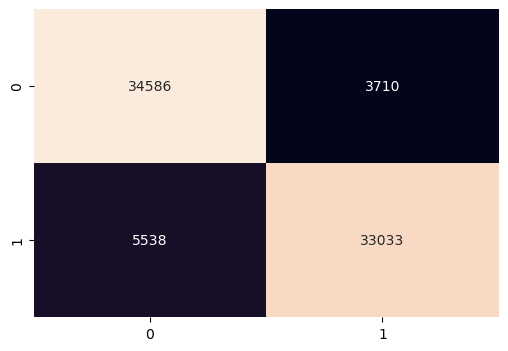

In [60]:
y_pred = logistic_model(X_train_bag_of_words, y_train, X_test_bag_of_words)
check_metrics(y_test, y_pred)

### Train & test using TF-IDF

Accuracy Score:  0.878998790117996
Classification Report:                precision    recall  f1-score   support

           0       0.86      0.90      0.88     38296
           1       0.90      0.86      0.88     38571

    accuracy                           0.88     76867
   macro avg       0.88      0.88      0.88     76867
weighted avg       0.88      0.88      0.88     76867



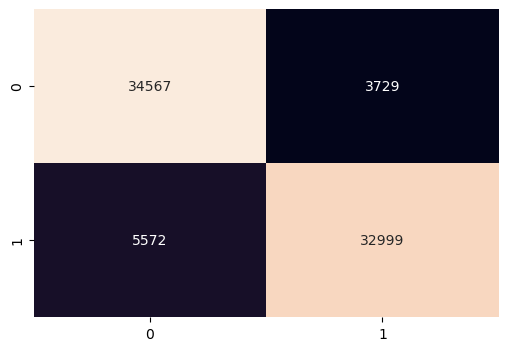

In [61]:
y_pred = logistic_model(X_train_tfidf, y_train, X_test_tfidf)
check_metrics(y_test, y_pred)

### Naive Bais Model

In [62]:
def naive_bais_model(x_train, y_train, x_test):
    model = MultinomialNB()
    model.fit(X_train_bag_of_words, y_train)
    return model.predict(X_test_bag_of_words)


### Train & test using Bag of words

Accuracy Score:  0.7900399391156153
Classification Report:                precision    recall  f1-score   support

           0       0.81      0.76      0.78     38296
           1       0.78      0.82      0.80     38571

    accuracy                           0.79     76867
   macro avg       0.79      0.79      0.79     76867
weighted avg       0.79      0.79      0.79     76867



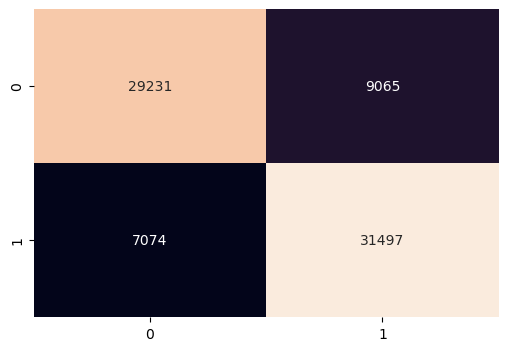

In [63]:
y_pred = naive_bais_model(X_train_bag_of_words, y_train, X_test_bag_of_words)
check_metrics(y_test, y_pred)

### Train & test using TF-IDF

Accuracy Score:  0.7900399391156153
Classification Report:                precision    recall  f1-score   support

           0       0.81      0.76      0.78     38296
           1       0.78      0.82      0.80     38571

    accuracy                           0.79     76867
   macro avg       0.79      0.79      0.79     76867
weighted avg       0.79      0.79      0.79     76867



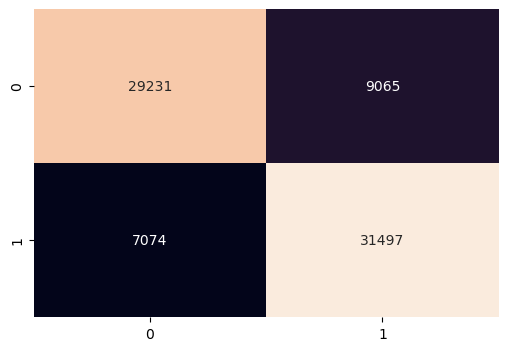

In [64]:
y_pred = naive_bais_model(X_train_tfidf, y_train, X_test_tfidf)
check_metrics(y_test, y_pred)

**Logistic Regression performs better than Naive Bayes using both bag of words and TF-IDF. The accuracy is high and also precision and recall is high in logistic regression**